Note: 
In our paper, the efficiency comparison was performed on the CPU. Our code design involves list-based operations, which prevent the use of CUDA acceleration. To enable CUDA acceleration, an M×M coefficient matrix can be constructed, where M represents the number of collocation points. Specifically, each row of this matrix stores the coefficients (encompassing all collocation points) corresponding to a reference point. However, only N coefficients per row are nonzero, where N is the number of supporting points. While this approach facilitates CUDA acceleration, it substantially increases memory consumption. Overall, theoretically, the RBFDQ method is more efficient than the AD method.

Reference：

[1]Xiao Y, Yang LM, Du YJ, et al. Radial basis function-differential quadrature-based physics-informed neural network for steady incompressible flows. Physics of Fluids, 2023, 35(7):073607. 

[2]Xiao Y, Yang LM, Shu C, et al. Least-square finite difference-based physics-informed neural network for steady incompressible flows. Computers & Mathematics with Applications. 2024, 75:33-48.

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import sys
import os
import numpy as np
import json
import scipy.io
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import pandas
from pandas import DataFrame
import openturns as ot
import xlwt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

In [2]:
np.random.seed(1234)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cpu')

In [3]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = layers
        self.layer1 = nn.Sequential(nn.Linear(layers[0], layers[1]),nn.Tanh(),nn.BatchNorm1d(layers[1]))
        self.layer2 = nn.Sequential(nn.Linear(layers[1], layers[2]),nn.Tanh(),nn.BatchNorm1d(layers[2]))
        self.layer3 = nn.Sequential(nn.Linear(layers[2], layers[3]),nn.Tanh(),nn.BatchNorm1d(layers[3]))
        self.layer4 = nn.Sequential(nn.Linear(layers[3], layers[4]),nn.Tanh(),nn.BatchNorm1d(layers[4]))
        self.layer5 = nn.Sequential(nn.Linear(layers[4], layers[5]),nn.Tanh(),nn.BatchNorm1d(layers[4]))
        self.layer6 = nn.Sequential(nn.Linear(layers[5], layers[6]),nn.Tanh(),nn.BatchNorm1d(layers[4]))
        #self.layer7 = nn.Sequential(nn.Linear(layers[6], layers[7]),nn.Tanh())
        #self.layer8 = nn.Sequential(nn.Linear(layers[7], layers[8]),nn.Tanh())
        self.layer9 = nn.Sequential(nn.Linear(layers[8], layers[9]))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        #x = self.layer7(x)
        #x = self.layer8(x)
        x = self.layer9(x)
        return x

In [ ]:
class PINNS(DNN):
    def __init__(self, layers, X_f, L, Lx1, Ly1, Lx2, Ly2):
        super(PINNS, self).__init__(layers)
        
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad = True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad = True).float().to(device)
        self.Lx1 = torch.tensor(Lx1, requires_grad = True).float().to(device) 
        self.Ly1 = torch.tensor(Ly1, requires_grad = True).float().to(device)
        self.Lx2 = torch.tensor(Lx2, requires_grad = True).float().to(device)
        self.Ly2 = torch.tensor(Ly2, requires_grad = True).float().to(device)
        ## self.L1 is list
        self.L1 = L
        self.dnn = DNN(layers).to(device)
        
        self.epoch = 0

        

        # u（x，t）
    def u_model(self, x, t):
        u = self.dnn(torch.cat([x, t], dim = 1))
        return u
    
        # AD-PINN
    def f_model(self, x, y):
        u_f = self.u_model(x, y)
        u = self.f_y(y) + x*y*(x-1)*(y-1)*u_f[:, 0:1]
        v = x*y*(x-1)*(y-1)*u_f[:, 1:2]
        p = u_f[:, 2:3]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_y = torch.autograd.grad(
            v, y, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]

        p_x = torch.autograd.grad(
            p, x, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]
        
        p_y = torch.autograd.grad(
            p, y, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]

        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_yy = torch.autograd.grad(
            v_y, y, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u * u_x + v * u_y - (1.0/1000) * (u_xx + u_yy) + p_x
        g = u * v_x + v * v_y - (1.0/1000) * (v_xx + v_yy) + p_y
        h = u_x + v_y

        return f, g, h

    def f_y(self, t):
        p1 = torch.zeros_like(t)
        p2 = torch.where(t == 1.0, t, p1)
        return p2
    
    ## RBFDQ-PINN-II
    def f1_model(self, x, t):
        u = self.u_model(x, t)
        u11 = u[:, 0:1]
        v11 = u[:, 1:2]
        p11 = u[:, 2:3]
        Mx = My = 101
        deltax = 1/(Mx-1)
        deltay = 1/(My-1)
        
        u_x1 = torch.squeeze(torch.bmm(self.Lx1,u11[self.L1]),2).reshape(My,Mx)   ## u11[self.L1] involves list-based operations, which prevent the use of CUDA acceleration.
        u_y1 = torch.squeeze(torch.bmm(self.Ly1,u11[self.L1]),2).reshape(My,Mx)
        u_xx1 = torch.squeeze(torch.bmm(self.Lx2,u11[self.L1]),2).reshape(My,Mx)
        u_yy1 = torch.squeeze(torch.bmm(self.Ly2,u11[self.L1]),2).reshape(My,Mx)
        v_x1 = torch.squeeze(torch.bmm(self.Lx1,v11[self.L1]),2).reshape(My,Mx)
        v_y1 = torch.squeeze(torch.bmm(self.Ly1,v11[self.L1]),2).reshape(My,Mx)
        v_xx1 = torch.squeeze(torch.bmm(self.Lx2,v11[self.L1]),2).reshape(My,Mx)
        v_yy1 = torch.squeeze(torch.bmm(self.Ly2,v11[self.L1]),2).reshape(My,Mx)
        p_x1 = torch.squeeze(torch.bmm(self.Lx1,p11[self.L1]),2).reshape(My,Mx)
        p_y1 = torch.squeeze(torch.bmm(self.Ly1,p11[self.L1]),2).reshape(My,Mx)


        u_11 = u11.reshape(My,Mx)
        v_11 = v11.reshape(My,Mx)
        p_11 = p11.reshape(My,Mx)


        
        u_11[0,:] = u_11[:,0] = u_11[:,-1] = 0.0
        u_11[-1,:] = 1.0 
        v_11[-1,:] = v_11[0,:] = v_11[:,0] = v_11[:,-1] = 0.0 
        

        u_x2 = (u_11[1:My-1,2:Mx] - u_11[1:My-1,0:Mx-2])/(2*deltax)
        u_y2 = (u_11[2:My,1:Mx-1] - u_11[0:My-2,1:Mx-1])/(2*deltay)
        u_xx2 = (u_11[1:My-1,2:Mx] + u_11[1:My-1,0:Mx-2] - 2.0*u_11[1:My-1,1:Mx-1])/(deltax**2)
        u_yy2 = (u_11[2:My,1:Mx-1] + u_11[0:My-2,1:Mx-1] - 2.0*u_11[1:My-1,1:Mx-1])/(deltay**2)
        v_x2 = (v_11[1:My-1,2:Mx] - v_11[1:My-1,0:Mx-2])/(2*deltax)
        v_y2 = (v_11[2:My,1:Mx-1] - v_11[0:My-2,1:Mx-1])/(2*deltay)
        v_xx2 = (v_11[1:My-1,2:Mx] + v_11[1:My-1,0:Mx-2] - 2.0*v_11[1:My-1,1:Mx-1])/(deltax**2)
        v_yy2 = (v_11[2:My,1:Mx-1] + v_11[0:My-2,1:Mx-1] - 2.0*v_11[1:My-1,1:Mx-1])/(deltay**2)
        p_x2 = (p_11[1:My-1,2:Mx] - p_11[1:My-1,0:Mx-2])/(2*deltax)
        p_y2 = (p_11[2:My,1:Mx-1] - p_11[0:My-2,1:Mx-1])/(2*deltay)
        
        u_x2[2:My-4,2:Mx-4] = u_x1[3:My-3,3:Mx-3] 
        u_y2[2:My-4,2:Mx-4] = u_y1[3:My-3,3:Mx-3] 
        u_xx2[2:My-4,2:Mx-4] = u_xx1[3:My-3,3:Mx-3] 
        u_yy2[2:My-4,2:Mx-4] = u_yy1[3:My-3,3:Mx-3] 
        v_x2[2:My-4,2:Mx-4] = v_x1[3:My-3,3:Mx-3] 
        v_y2[2:My-4,2:Mx-4] = v_y1[3:My-3,3:Mx-3] 
        v_xx2[2:My-4,2:Mx-4] = v_xx1[3:My-3,3:Mx-3] 
        v_yy2[2:My-4,2:Mx-4] = v_yy1[3:My-3,3:Mx-3]  
        p_x2[2:My-4,2:Mx-4] = p_x1[3:My-3,3:Mx-3] 
        p_y2[2:My-4,2:Mx-4] = p_y1[3:My-3,3:Mx-3]


        f = u_x2 + v_y2
        g = u_11[1:My-1,1:Mx-1]*u_x2 + v_11[1:My-1,1:Mx-1]*u_y2 + p_x2 - (1/1000)*(u_xx2 + u_yy2)
        h = u_11[1:My-1,1:Mx-1]*v_x2 + v_11[1:My-1,1:Mx-1]*v_y2 + p_y2 - (1/1000)*(v_xx2 + v_yy2)


        return f, g, h

        # loss function
    def loss_fun(self):
        self.optimizer.zero_grad()

        

        f_net, g_net, h_net = self.f1_model(self.x_f, self.t_f)

        loss =torch.mean(h_net **2) + torch.mean(f_net **2) + torch.mean(g_net **2)

        loss.backward()

        self.epoch += 1
        
        if self.epoch % 100 ==0:
            print('Epoch:{}, loss:{:5e}'.\
                format(self.epoch, loss.item()))
        
        return loss

        #
    def Adam_train(self, l_r, epochs):
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=l_r, betas=(0.9, 0.999), eps=1e-08)
        for i in range(epochs):
            self.dnn.train()
            self.optimizer.step(self.loss_fun)

    def SGD_train(self, l_r, epochs):
        self.optimizer = torch.optim.SGD(self.dnn.parameters(), lr=l_r, momentum=0.9)
        for i in range(epochs):
            self.dnn.train()
            self.optimizer.step(self.loss_fun)
        
    def LBFGS_train(self):
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=100000, 
            max_eval=100000, 
            history_size=50,
            tolerance_grad=1e-10, 
            tolerance_change=1.0 * np.finfo(float).eps,
            #line_search_fn="strong_wolfe"       
        )
        self.dnn.train()
        self.optimizer.step(self.loss_fun)

    def predict(self, x, y):
        x = torch.tensor(x, requires_grad = True).float().to(device)
        y = torch.tensor(y, requires_grad = True).float().to(device)
        self.dnn.eval()

        u = self.u_model(x, y)

        u_1 = u[:, 0:1]
        u_2 = u[:, 1:2]
        u_3 = u[:, 2:3]

        return u_1.detach().cpu().numpy(), u_2.detach().cpu().numpy(), u_3.detach().cpu().numpy()


In [ ]:
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 3]

x0 = np.linspace(0.0,1.0,101)
y0 = np.linspace(0.0,1.0,101)
X0,T0 = np.meshgrid(x0, y0)
X_f_train = np.hstack((X0.flatten()[:,None], T0.flatten()[:,None]))
##  Uniform Mesh
X_f_train_x = X_f_train[:,0].reshape(101,101)
X_f_train_y = X_f_train[:,1].reshape(101,101)

##  Halton Sequence
"""sequence1 = ot.LowDiscrepancySequence(ot.HaltonSequence(2))
d1 = sequence1.generate(8649)
d1 = np.array(d1)# Convert a data type to an array
d1 = d1*0.92+0.04
X_f_train_x[4:97,4:97] = d1[:,0].reshape(93,93)
X_f_train_y[4:97,4:97] = d1[:,1].reshape(93,93)"""

##  Harmmersley Sequence
"""sequence1 = ot.LowDiscrepancySequence(ot.HaltonSequence(1))
d1 = sequence1.generate(8649)
d1 = np.array(d1)# 
a = np.zeros((8649,1))
for i in range(8649):
    a[i] = i/8649 
d1 = d1*0.92+0.04
a = a*0.92+0.04

X_f_train_x[4:97,4:97] = a.reshape(93,93)
X_f_train_y[4:97,4:97] = d1.reshape(93,93)"""

X_f_train = np.hstack((X_f_train_x.flatten()[:,None], X_f_train_y.flatten()[:,None]))


def MQRBF(x1,x2,c,D):
    return np.sqrt((x1[0]/D - x2[0]/D)**2 + (x1[1]/D - x2[1]/D)**2 + (c/D)**2)

def D1x_MQRBF(x1,x2,c,D):
    return (x1[0]/D**2 - x2[0]/D**2)/MQRBF(x1,x2,c,D)

def D1y_MQRBF(x1,x2,c,D):
    return (x1[1]/D**2 - x2[1]/D**2)/MQRBF(x1,x2,c,D)

def D2x_MQRBF(x1,x2,c,D):
    return (MQRBF(x1,x2,c,D)/D**2 - (x1[0]/D**2 - x2[0]/D**2)*D1x_MQRBF(x1,x2,c,D))/(MQRBF(x1,x2,c,D))**2

def D2y_MQRBF(x1,x2,c,D):
    return (MQRBF(x1,x2,c,D)/D**2 - (x1[1]/D**2 - x2[1]/D**2)*D1y_MQRBF(x1,x2,c,D))/(MQRBF(x1,x2,c,D))**2

def Matrix(X_star, N_f, n,c,D):
    L = np.zeros((N_f, N_f))
    for i in range(N_f):
        for j in range(N_f):
            L[i,j] = np.sqrt((X_star[j,0] - X_star[i,0])**2 + (X_star[j,1] - X_star[i,1])**2)

    List = []
   
    for i in range(N_f):
        temp = []
        temp1 = []
        Inf = 10
        LL = L[i,:].tolist()
        for k in range(n+1):
            temp.append(LL.index(min(LL)))
            temp1.append(LL[LL.index(min(LL))])
            LL[LL.index(min(LL))]=Inf

        temp[0], temp[temp1.index(min(temp1))] = temp[temp1.index(min(temp1))], temp[0]
        temp[n], temp[temp1.index(max(temp1))] = temp[temp1.index(max(temp1))], temp[n]
        List.append(temp)
    

    print(len(List))

    M = np.zeros((N_f, n+1, n+1))
    M1 = np.zeros((n+1,n+1))
    M_dx1 = np.zeros((N_f, n+1, 1))
    M_dy1 = np.zeros((N_f, n+1, 1))
    M_dx2 = np.zeros((N_f, n+1, 1))
    M_dy2 = np.zeros((N_f, n+1, 1))

    for i in range(N_f):
        for j in range(n+1):
            #M_dx1[i,j,:] = D1x_MQRBF(X_star[List[i][0],:], X_star[List[i][j],:], np.sqrt(10.5)*L[i,List[i][n]], L[i,List[i][n]])
            M_dx1[i,j,:] = D1x_MQRBF(X_star[List[i][0],:], X_star[List[i][j],:], c,D)
            M_dy1[i,j,:] = D1y_MQRBF(X_star[List[i][0],:], X_star[List[i][j],:], c,D)
            M_dx2[i,j,:] = D2x_MQRBF(X_star[List[i][0],:], X_star[List[i][j],:], c,D)
            M_dy2[i,j,:] = D2y_MQRBF(X_star[List[i][0],:], X_star[List[i][j],:], c,D)

    for i in range(N_f):
        for j in range(n+1):
            for k in range(n+1):
                M1[j, k] = MQRBF(X_star[List[i][j],:], X_star[List[i][k],:], c,D)

        M[i,:,:] = np.linalg.inv(M1)

    L1x = np.matmul(M, M_dx1).reshape(N_f, 1, n+1)
    L1y = np.matmul(M, M_dy1).reshape(N_f, 1, n+1)
    L2x = np.matmul(M, M_dx2).reshape(N_f, 1, n+1)
    L2y = np.matmul(M, M_dy2).reshape(N_f, 1, n+1)

    return L1x, L1y, L2x, L2y, List

10201


In [6]:
N_support = 20  ## Number of supporting points
c = 0.23        ## shape parameter
D = 1.0         
Lx1, Ly1, Lx2, Ly2, L1 = Matrix(X_f_train, X_f_train.shape[0], N_support,c,D)
print(Lx1.shape)
print(len(L1))

(10201, 1, 21)
10201


In [11]:
model = PINNS(layers, X_f_train, L1, Lx1, Ly1, Lx2, Ly2)

In [ ]:
%%time
               

model.Adam_train(0.001,200000)

In [149]:
%%time
               

model.Adam_train(0.0001,100000)

Epoch:200100, loss:2.977160e-05
Epoch:200200, loss:2.961170e-05
Epoch:200300, loss:2.953050e-05
Epoch:200400, loss:2.939990e-05
Epoch:200500, loss:2.927128e-05
Epoch:200600, loss:3.009976e-05
Epoch:200700, loss:2.911338e-05
Epoch:200800, loss:2.916044e-05
Epoch:200900, loss:2.888875e-05
Epoch:201000, loss:2.906769e-05
Epoch:201100, loss:2.894201e-05
Epoch:201200, loss:2.906939e-05
Epoch:201300, loss:2.855765e-05
Epoch:201400, loss:2.876273e-05
Epoch:201500, loss:2.848689e-05
Epoch:201600, loss:2.846624e-05
Epoch:201700, loss:2.826114e-05
Epoch:201800, loss:2.859233e-05
Epoch:201900, loss:2.832301e-05
Epoch:202000, loss:2.801838e-05
Epoch:202100, loss:2.805068e-05
Epoch:202200, loss:2.885873e-05
Epoch:202300, loss:2.843555e-05
Epoch:202400, loss:2.939773e-05
Epoch:202500, loss:2.802467e-05
Epoch:202600, loss:3.081228e-05
Epoch:202700, loss:2.782322e-05
Epoch:202800, loss:2.798897e-05
Epoch:202900, loss:2.756319e-05
Epoch:203000, loss:2.749403e-05
Epoch:203100, loss:2.844440e-05
Epoch:20

In [150]:
%%time
               

model.LBFGS_train()

Epoch:300100, loss:1.625374e-05
Epoch:300200, loss:1.623837e-05
Epoch:300300, loss:1.622841e-05
Epoch:300400, loss:1.623704e-05
Epoch:300500, loss:1.623959e-05
Epoch:300600, loss:1.624196e-05
Epoch:300700, loss:1.624152e-05
Epoch:300800, loss:1.624225e-05
Epoch:300900, loss:1.623932e-05
Epoch:301000, loss:1.625096e-05
Epoch:301100, loss:1.624915e-05
Epoch:301200, loss:1.625517e-05
Epoch:301300, loss:1.625632e-05
Epoch:301400, loss:1.625446e-05
Epoch:301500, loss:1.625534e-05
Epoch:301600, loss:1.625540e-05
Epoch:301700, loss:1.624053e-05
Epoch:301800, loss:1.625204e-05
Epoch:301900, loss:1.625909e-05
Epoch:302000, loss:1.625318e-05
Epoch:302100, loss:1.625682e-05
Epoch:302200, loss:1.625296e-05
Epoch:302300, loss:1.625721e-05
Epoch:302400, loss:1.624618e-05
Epoch:302500, loss:1.624688e-05
Epoch:302600, loss:1.624224e-05
Epoch:302700, loss:1.624836e-05
Epoch:302800, loss:1.624833e-05
Epoch:302900, loss:1.625055e-05
Epoch:303000, loss:1.624590e-05
Epoch:303100, loss:1.625272e-05
Epoch:30

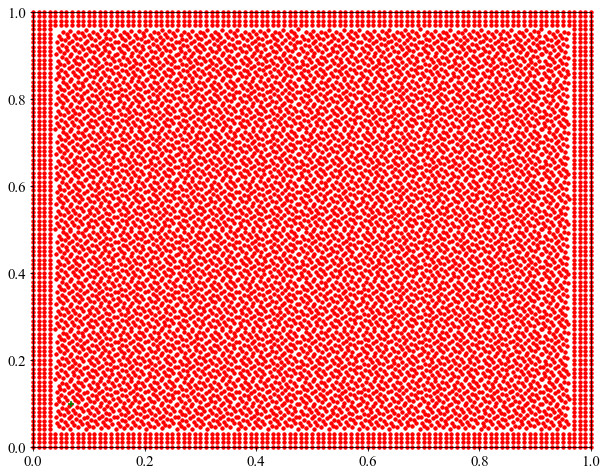

In [151]:
font = {'family': 'Times New Roman',}
font1 = {'family': 'Times New Roman','style': 'italic',}
fig = plt.figure(figsize=(10, 8))
plt.tick_params(labelsize=15)
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
i = 687
#x1 = X_f_train[L1[i],:]

#plt.scatter(x1[:,0],x1[:,1],c = 'k',marker='*',clip_on = False)
plt.scatter(model.x_f.detach().cpu().numpy(),model.t_f.detach().cpu().numpy(),c = 'r',marker='.',clip_on = False)
plt.scatter(X_f_train[:,0],X_f_train[:,1],c = 'r',marker='.',clip_on = False)
plt.scatter(X_f_train[i,0],X_f_train[i,1],c = 'g',marker='+',clip_on = False)
#plt.scatter(X_f_train[L1[i][15],0],X_f_train[L1[i][15],1],c = 'y',marker='o',clip_on = False)
#plt.scatter(X_f_train[L1[i][0],0],X_f_train[L1[i][0],1],c = 'y',marker='o',clip_on = False)
plt.show()

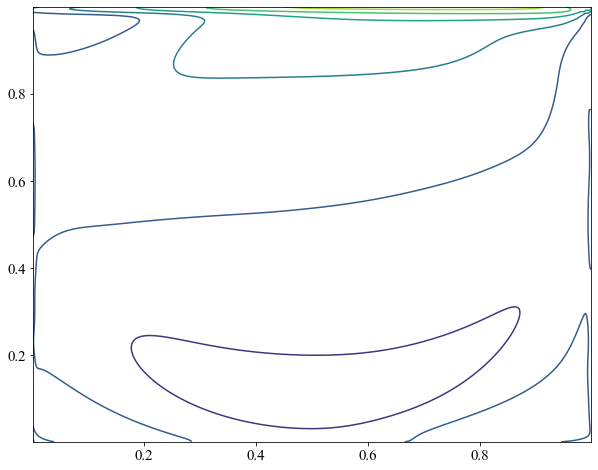

In [160]:
Mx = My = 200
dx = dy = 1/Mx
x = np.linspace(0,1,Mx+1)[:,None]
y = np.linspace(0,1,My+1)[:,None]
X, Y = np.meshgrid(x[1:Mx+1]-dx/2.0, y[1:My+1]-dy/2.0)
#x_star = np.linspace(0, 1, Mx)[:,None]
#y_star = np.linspace(0, 1, My)[:,None]
#X, Y = np.meshgrid(x_star, y_star)
X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
x_1 = X_star[:,0:1]
y_1 = X_star[:,1:2]     
u_pred, v_pred, p_pred = model.predict(x_1, y_1)

#U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
#V_pred = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
U_pred = u_pred.reshape(Mx,My)
V_pred = v_pred.reshape(Mx,My)
P_pred = p_pred.reshape(Mx,My)
#U_pred[0,:] = U_pred[:,0] = U_pred[:,-1] = 0.0
#U_pred[-1,:] = 1.0 
#V_pred[-1,:] = V_pred[0,:] = V_pred[:,0] = V_pred[:,-1] = 0.0 
fig = plt.figure(figsize=(10, 8))
plt.tick_params(labelsize=15)
plt.contour(X,Y,U_pred)
plt.show()

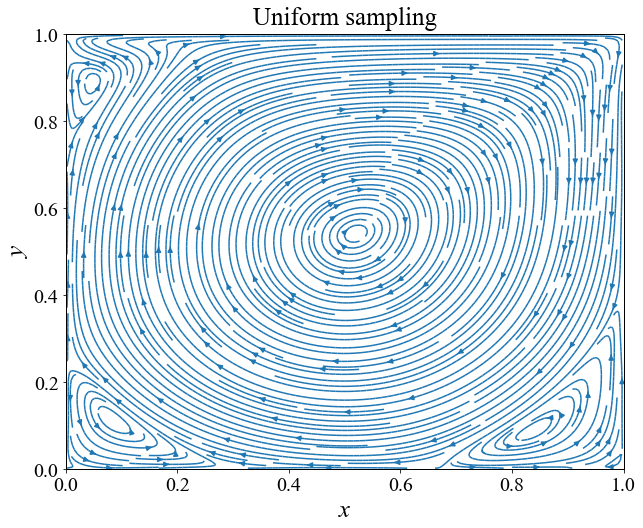

In [38]:
fig = plt.figure(figsize=(10, 8))
plt.streamplot(X,Y,U_pred,V_pred,density=3)
plt.tick_params(labelsize=20)
plt.xlim(0.0,1.0)
plt.xlabel('x', size=25,fontdict = font1)
plt.ylabel('y', size=25,fontdict = font1)
plt.title(r"Uniform sampling", size = 25, pad =10)
plt.ylim(0.0,1.0)
fig1=plt.gcf()
ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(1)###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(1)####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(1)###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(1)
#plt.savefig('RBFDQ-PINN/Case2-Lid_Cavity/Streamline_1000_Uniform.jpg', format='jpg', dpi=200)
plt.show()

In [161]:
import pandas
from pandas import DataFrame
import xlwt

L_LBFS = np.concatenate([X.flatten()[:,None], Y.flatten()[:,None], U_pred.flatten()[:,None], V_pred.flatten()[:,None], P_pred.flatten()[:,None]], 1)
dataframe_LBFS = pandas.DataFrame(L_LBFS)
#dataframe_LBFS.to_csv('RBF_Cavity_tecplot_1000_400_400_Hammersley_1.csv')

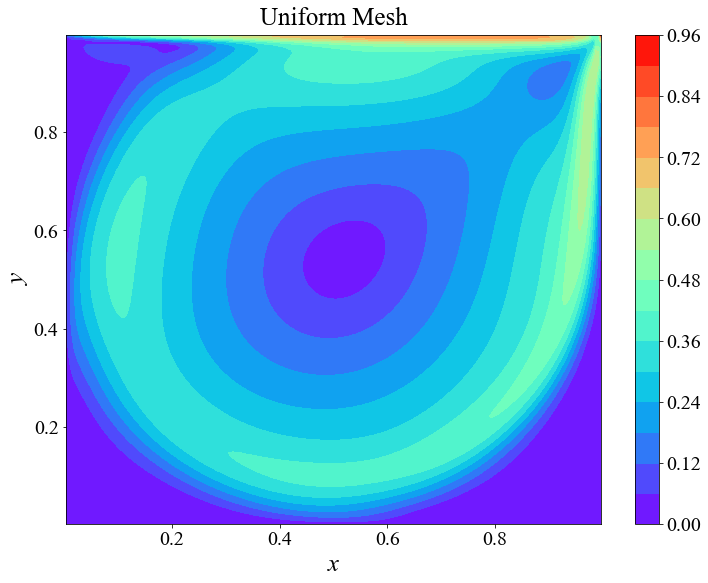

In [69]:
fig = plt.figure(figsize=(12, 9))
ax = plt.contourf(X,Y,np.sqrt(U_pred**2+V_pred**2), 15,cmap='rainbow',levels=np.linspace(0,0.96,17))
#plt.colorbar(ax)
ax1 = plt.colorbar(ax)
ax1.ax.tick_params(labelsize=20) 
plt.xlabel('x',size=25,fontdict = font1)
plt.ylabel('y',size=25,fontdict = font1)
plt.tick_params(labelsize=20)
plt.title("Uniform Mesh",fontsize = 25,pad=10)
plt.rcParams['font.sans-serif'] = 'Times New Roman'
#plt.savefig('RBFDQ-PINN\Case2-Lid_Cavity\Re=1000\Contouf_1000_Uniform_RBFDQ.jpg', format='jpg', dpi=200)
plt.show()

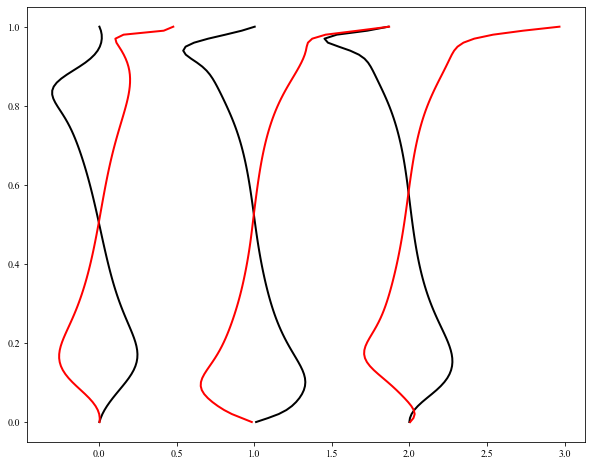

In [156]:
x_11 = np.linspace(0.0, 1.0, 100)[:,None]

y_11 = np.array([0.25]*100)[:,None]
y_22 = np.array([0.5]*100)[:,None]
y_33 = np.array([0.75]*100)[:,None]
u_pred1, v_pred1, p_pred1 = model.predict(x_11, y_11)
u_pred2, v_pred2, p_pred2 = model.predict(x_11, y_22)
u_pred3, v_pred3, p_pred3 = model.predict(x_11, y_33)

u_pred11, v_pred11, p_pred11 = model.predict(y_11, x_11)
u_pred22, v_pred22, p_pred22 = model.predict(y_22, x_11)
u_pred33, v_pred33, p_pred33 = model.predict(y_33, x_11)

fig = plt.figure(figsize=(10, 8))
plt.plot(v_pred1, x_11,"k-",label='Exact',linewidth = 2)
plt.plot(v_pred2+1.0, x_11,"k-",label='Exact',linewidth = 2)
plt.plot(v_pred3+2.0, x_11,"k-",label='Exact',linewidth = 2)

plt.plot(u_pred11, x_11,"r-",label='Exact',linewidth = 2)
plt.plot(u_pred22+1.0, x_11,"r-",label='Exact',linewidth = 2)
plt.plot(u_pred33+2.0, x_11,"r-",label='Exact',linewidth = 2)
plt.show()

(200, 1)


d:\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


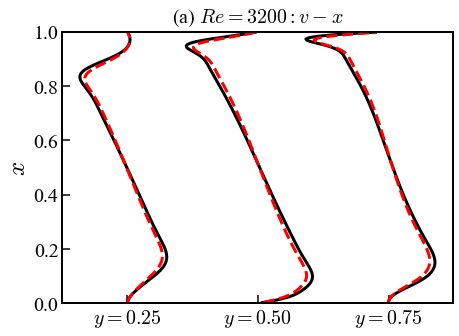

In [ ]:
u_1000 = pandas.read_excel("LBFS-1000-u.xls")
v_1000 = pandas.read_excel("LBFS-1000-v.xls")

u_1000 = np.array(u_1000)
u_1000 = 10*u_1000[:,1:]
v_1000 = np.array(v_1000)
v_1000 = 10*v_1000[:,1:]





x_1 = np.linspace(0.0, 1.0, 201)[:,None]

x_1 = x_1 - 1.0/200/2
x_1 = x_1[1:]
x_1 = x_1.reshape(200,1)
print(x_1.shape)

u1 = u_1000.T
v1 = v_1000.T

v_ex1 = v1[:,49][:,None]
v_ex2 = v1[:,99][:,None]
v_ex3 = v1[:,149][:,None]

u_ex11 = u1[49,:][:,None]
u_ex22 = u1[99,:][:,None]
u_ex33 = u1[149,:][:,None]

import matplotlib
font = {'family': 'Times New Roman',}
font1 = {'family': 'Times New Roman','style': 'italic',}
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
plt.ylabel('$x$', size=25,fontdict = font1)
plt.title('$Re=1000: v-x$', size=20,fontdict = font,pad = 10)
plt.xticks([0.0,1.0,2.0],(["$y = 0.25$","$y = 0.50$","$y = 0.75$"]))
plt.rcParams["font.style"] = 'normal'
plt.tick_params(labelsize=20)
plt.ylim(0.0,1.0)
plt.plot(v_ex1, x_1,"k-",label='CFD',linewidth = 3)
plt.plot(v_ex2+1.0, x_1,"k-",linewidth = 3)
plt.plot(v_ex3+2.0, x_1,"k-",linewidth = 3)
#plt.plot(v_pred1, x_11,"r--",label='RBFDQ-PINN',linewidth = 3)
#plt.plot(v_pred2+1.0, x_11,"r--",linewidth = 3)
#plt.plot(v_pred3+2.0, x_11,"r--",linewidth = 3)
plt.plot(V_pred[49,:][:,None], x_1,"r--",label='RBFDQ-PINN',linewidth = 3)
plt.plot(V_pred[99,:][:,None]+1.0, x_1,"r--",linewidth = 3)
plt.plot(V_pred[149,:][:,None]+2.0, x_1,"r--",linewidth = 3)
ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(2)###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)####设置左边坐标轴的粗细
axes = plt.subplot()
axes.minorticks_on()
axes.tick_params(axis="both", which="major", direction="in", width=1.5, length=8)
axes.tick_params(axis="both", which="minor", direction="in", width=0, length=0) 
#plt.savefig(r'C:\Users\Dell\Desktop\RBFDQ_cavity_3200_v.png', format='png', dpi=200)
plt.show()

d:\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


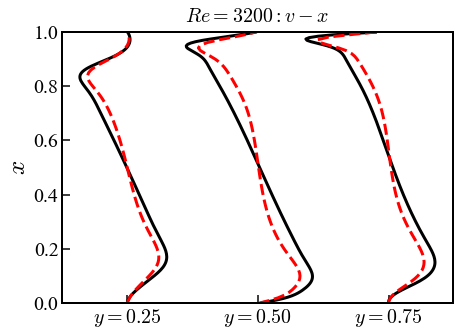

In [102]:
import matplotlib
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
plt.ylabel('$y$', size=25,fontdict = font1)
plt.title('$Re=1000: u-y$', size=20,fontdict = font1,pad = 10)
plt.xticks([0.0,1.0,2.0],(["$x = 0.25$","$x = 0.50$","$x = 0.75$"]))
plt.rcParams["font.style"] = 'normal'
plt.tick_params(labelsize=20)
plt.ylim(0.0,1.0)
plt.plot(u_ex11, x_1,"k-",label='CFD',linewidth = 3)
plt.plot(u_ex22+1.0, x_1,"k-",linewidth = 3)
plt.plot(u_ex33+2.0, x_1,"k-",linewidth = 3)
#plt.plot(u_pred11, x_11,"r--",label='RBFDQ-PINN',linewidth = 3)
#plt.plot(u_pred22+1.0, x_11,"r--",linewidth = 3)
#plt.plot(u_pred33+2.0, x_11,"r--",linewidth = 3)
plt.plot(U_pred[:,49][:,None], x_1,"r--",label='RBFDQ-PINN',linewidth = 3)
plt.plot(U_pred[:,99][:,None]+1.0, x_1,"r--",linewidth = 3)
plt.plot(U_pred[:,149][:,None]+2.0, x_1,"r--",linewidth = 3)
ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(2)###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)####设置左边坐标轴的粗细
axes = plt.subplot()
axes.minorticks_on()
axes.tick_params(axis="both", which="major", direction="in", width=1.5, length=8)
axes.tick_params(axis="both", which="minor", direction="in", width=0, length=0) 
plt.show()

d:\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
d:\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


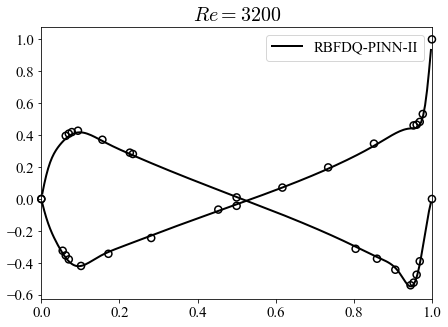

In [74]:
fig = plt.figure(figsize=(7, 5))
#plt.xlabel('$x$', size=20)
#plt.ylabel('$y$', size=20)
plt.title('$Re=1000$', size=20)
#plt.xticks([0.0,0.5,1.0,1.5,2.0],(["$x=0.25$","$x=0.50$","$x=0.75$","",""]))
plt.tick_params(labelsize=15)
#plt.xlim(0.0,1.0)


plt.xlim(0.0,1.0)
#plt.ylim(-0.7,1.1)

plt.plot(x_1,u_ex22,'k-',label='RBFDQ-PINN-II',linewidth = 2,)
plt.legend(loc=0,ncol=1,fontsize=15)
plt.plot(x_1,v_ex2,'k-',label='RBFDQ-PINN-II',linewidth = 2,)

##Re = 100
#L1 = np.array([1.0, 0.84123, 0.78871, 0.73722, 0.68717, 0.23151, 0.00332, -0.13641, -0.20581, -0.2109, -0.15662, -0.1015, -0.06434, -0.04775, -0.04192, -0.03717, 0.0])
#L2 = np.array([1.0,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5,0.4531,0.2813,0.1717,0.1016,0.0703,0.0625,0.0547,0.0])
#L3 = np.array([1.0,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,0.5,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0.0])
#L4 = np.array([0.0,-0.05906,-0.07391,-0.08864,-0.10313,-0.16914,-0.22445,-0.24533,0.05454,0.17527,0.17507,0.16077,0.12317,0.1089,0.10091,0.09233,0.0])
##Re = 1000
L1 = np.array([1.0, 0.65928, 0.57492, 0.51117, 0.46604, 0.33304, 0.18719, 0.05702, -0.0608, -0.10648, -0.27805, -0.38289, -0.2973, -0.2222, -0.20196, -0.18109, 0.0])
L2 = np.array([1.0,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5,0.4531,0.2813,0.1717,0.1016,0.0703,0.0625,0.0547,0.0])
L3 = np.array([1.0,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,0.5,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0.0])
L4 = np.array([0.0,-0.21388,-0.27669,-0.33714,-0.39188,-0.5155,-0.42665,-0.31966,0.02526,0.32235,0.33075,0.37095,0.32627,0.30353,0.29012,0.27485,0.0])
##Re = 5000
#L1 = np.array([1.0, 0.48223, 0.46120, 0.45992, 0.46036, 0.33556, 0.20087, 0.08183, -0.03039, -0.07404, -0.22855, -0.33050, -0.40435, -0.43643, -0.42901, -0.41165, 0.0])
#L2 = np.array([1.0,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5,0.4531,0.2813,0.1717,0.1016,0.0703,0.0625,0.0547,0.0])
#L3 = np.array([1.0,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,0.5,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0.0])
#L4 = np.array([0.0,-0.49774,-0.55069,-0.55408,-0.52876,-0.41442,-0.36214,-0.30018,0.00945,0.27280,0.28066,0.35368,0.42951,0.43648,0.43329,0.42447,0.0])
##Re = 3200
#L1 = np.array([1.0, 0.53236, 0.48296, 0.46547, 0.46101, 0.34682, 0.19791, 0.07156, -0.04272, -0.06636, -0.24427, -0.34323, -0.41933, -0.37827, -0.35344, -0.32407, 0.0])
#L2 = np.array([1.0,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5,0.4531,0.2813,0.1717,0.1016,0.0703,0.0625,0.0547,0.0])
#L3 = np.array([1.0,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,0.5,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0.0])
#L4 = np.array([0.0,-0.39017,-0.47425,-0.52357,-0.54053,-0.44307,-0.37401,-0.31184,0.00999,0.28188,0.29030,0.37119,0.42768,0.41906,0.40917,0.39560,0.0])
plt.scatter(L2, L1, c='',edgecolors='k',marker='o',s = 50,linewidths=1.5,clip_on = False)
plt.scatter(L3, L4, c='',edgecolors='k',marker='o',s = 50,linewidths=1.5,clip_on = False)
#plt.savefig('ARBFDQuv-xy_D.png', format='png', dpi=200)
plt.show()